In [27]:
# Cell 1: Import Libraries
# Import libraries for data analysis, visualization, and machine learning.

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    mean_squared_error, mean_absolute_error, r2_score, silhouette_score,
    roc_auc_score, roc_curve
)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import os

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [28]:
# Cell 2: Load and Check Data
# Load the dataset and verify it exists and has enough rows.

def load_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file at '{file_path}' was not found.")
    df = pd.read_csv(file_path)
    if len(df) < 30:
        raise ValueError(f"Dataset too small ({len(df)} rows). Need at least 30 rows.")
    print(f"Dataset loaded. Shape: {df.shape}")
    return df

# Call the function
file_path = '/Users/rahulyadav/Desktop/comprehensive_mutual_funds_data.csv'
df = load_data(file_path)

Dataset loaded. Shape: (814, 20)


In [29]:
# Cell 3: Exploratory Data Analysis (EDA)
# Perform comprehensive EDA to support all RQs.

def comprehensive_eda(df):
    print("="*60)
    print("📊 COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
    print("="*60)

    # Basic info
    print(f"\n🔹 Dataset Shape: {df.shape}")
    print(f"🔹 Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

    # Missing values analysis
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_table = pd.DataFrame({
        'Missing Count': missing_data,
        'Percentage': missing_percent
    }).sort_values('Missing Count', ascending=False)
    print("\n🔹 Missing Values Analysis:")
    print(missing_table[missing_table['Missing Count'] > 0])

    # Data types
    print("\n🔹 Data Types:")
    print(df.dtypes.value_counts())
    print("\n🔹 Columns of type 'object':", df.select_dtypes(include='object').columns.tolist())
    print("\n🔹 Columns of type 'int64':", df.select_dtypes(include='int64').columns.tolist())
    print("\n🔹 Columns of type 'float64':", df.select_dtypes(include='float64').columns.tolist())

    # Numerical columns statistics
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    print(f"\n🔹 Numerical Columns ({len(numerical_cols)}):")
    if not numerical_cols.empty:
        print(df[numerical_cols].describe())
    else:
        print("No numerical columns found.")

    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    print(f"\n🔹 Categorical Columns ({len(categorical_cols)}):")
    if not categorical_cols.empty:
        for col in categorical_cols:
            print(f"{col}: {df[col].nunique()} unique values")
    else:
        print("No categorical columns found.")

    # Outlier detection using IQR method
    print("\n🔹 Outlier Detection (IQR Method):")
    if not numerical_cols.empty:
        for col in numerical_cols:
            if col in df.columns and df[col].count() > 0:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
                print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")
    else:
        print("No numerical columns to check for outliers.")

# Call the function
comprehensive_eda(df)

📊 COMPREHENSIVE EXPLORATORY DATA ANALYSIS

🔹 Dataset Shape: (814, 20)
🔹 Memory usage: 0.12 MB

🔹 Missing Values Analysis:
             Missing Count  Percentage
returns_5yr            167   20.515971
returns_3yr             21    2.579853

🔹 Data Types:
object     10
int64       5
float64     5
Name: count, dtype: int64

🔹 Columns of type 'object': ['scheme_name', 'fund_manager', 'sortino', 'alpha', 'sd', 'beta', 'sharpe', 'amc_name', 'category', 'sub_category']

🔹 Columns of type 'int64': ['min_sip', 'min_lumpsum', 'fund_age_yr', 'risk_level', 'rating']

🔹 Columns of type 'float64': ['expense_ratio', 'fund_size_cr', 'returns_1yr', 'returns_3yr', 'returns_5yr']

🔹 Numerical Columns (10):
           min_sip   min_lumpsum  ...  returns_3yr  returns_5yr
count   814.000000    814.000000  ...   793.000000   647.000000
mean    528.500000   3047.468059  ...    18.525347     9.490726
std     369.184517   2514.619513  ...    12.108476     3.714015
min       0.000000      0.000000  ...     3.300

In [30]:
# Cell 4: Preprocess Data
# Clean numerical columns and encode categorical columns.

def advanced_preprocessing(df):
    print("\n🔧 ADVANCED PREPROCESSING")
    print("="*30)

    encoders = {}
    
    # Clean numerical columns
    num_cols = ['returns_1yr', 'returns_3yr', 'returns_5yr', 'sharpe', 'sortino', 'alpha', 'beta', 'sd', 'expense_ratio', 'fund_size_cr', 'fund_age_yr', 'rating']
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Impute missing values
    imputer_num = SimpleImputer(strategy='median')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    num_cols_present = [col for col in num_cols if col in df.columns]
    cat_cols = ['category', 'sub_category', 'risk_level', 'amc_name', 'fund_manager']
    cat_cols_present = [col for col in cat_cols if col in df.columns]

    if num_cols_present:
        df[num_cols_present] = imputer_num.fit_transform(df[num_cols_present])
    if cat_cols_present:
        df[cat_cols_present] = imputer_cat.fit_transform(df[cat_cols_present])

    # Encode categorical columns
    for col in cat_cols_present:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
        encoders[col] = le
        print(f"Encoded {col} into {col}_encoded")

    print("✅ Preprocessing completed")
    return df, encoders

# Call the function
df, encoders = advanced_preprocessing(df)


🔧 ADVANCED PREPROCESSING
Encoded category into category_encoded
Encoded sub_category into sub_category_encoded
Encoded risk_level into risk_level_encoded
Encoded amc_name into amc_name_encoded
Encoded fund_manager into fund_manager_encoded
✅ Preprocessing completed


In [31]:
# Cell 5: Feature Engineering
# Create derived features to support RQs.

def create_derived_features(df, encoders):
    print("\n🎯 FEATURE ENGINEERING")
    print("="*30)

    if all(col in df.columns for col in ['returns_1yr', 'sd']):
        df['risk_adjusted_return'] = df['returns_1yr'] / (df['sd'].replace(0, 1e-8) + 1e-8)
        print("Created 'risk_adjusted_return' feature.")
    else:
        print("Warning: 'returns_1yr' or 'sd' not found.")

    if 'fund_size_cr' in df.columns:
        df['fund_size_cr'] = pd.to_numeric(df['fund_size_cr'], errors='coerce')
        df['size_category'] = pd.cut(df['fund_size_cr'],
                                    bins=[0, 100, 1000, 5000, float('inf')],
                                    labels=['Small', 'Medium', 'Large', 'Very Large'],
                                    right=False)
        le_size = LabelEncoder()
        df['size_category'] = le_size.fit_transform(df['size_category'].astype(str))
        encoders['size_category'] = le_size
        print("Created and encoded 'size_category' feature.")
    else:
        print("Warning: 'fund_size_cr' not found.")

    if 'fund_age_yr' in df.columns:
        df['fund_age_yr'] = pd.to_numeric(df['fund_age_yr'], errors='coerce')
        df['age_category'] = pd.cut(df['fund_age_yr'],
                                   bins=[0, 2, 5, 10, float('inf')],
                                   labels=['New', 'Young', 'Mature', 'Veteran'],
                                   right=False)
        le_age = LabelEncoder()
        df['age_category'] = le_age.fit_transform(df['age_category'].astype(str))
        encoders['age_category'] = le_age
        print("Created and encoded 'age_category' feature.")
    else:
        print("Warning: 'fund_age_yr' not found.")

    if 'expense_ratio' in df.columns:
        df['expense_ratio'] = pd.to_numeric(df['expense_ratio'], errors='coerce')
        df['expense_category'] = pd.cut(df['expense_ratio'],
                                      bins=[0, 1, 2, 3, float('inf')],
                                      labels=['Low', 'Medium', 'High', 'Very High'],
                                      right=False)
        le_expense = LabelEncoder()
        df['expense_category'] = le_expense.fit_transform(df['expense_category'].astype(str))
        encoders['expense_category'] = le_expense
        print("Created and encoded 'expense_category' feature.")
    else:
        print("Warning: 'expense_ratio' not found.")

    print("✅ Feature engineering completed")
    return df, encoders

# Call the function
df, encoders = create_derived_features(df, encoders)


🎯 FEATURE ENGINEERING
Created 'risk_adjusted_return' feature.
Created and encoded 'size_category' feature.
Created and encoded 'age_category' feature.
Created and encoded 'expense_category' feature.
✅ Feature engineering completed



📈 CREATING VISUALIZATIONS


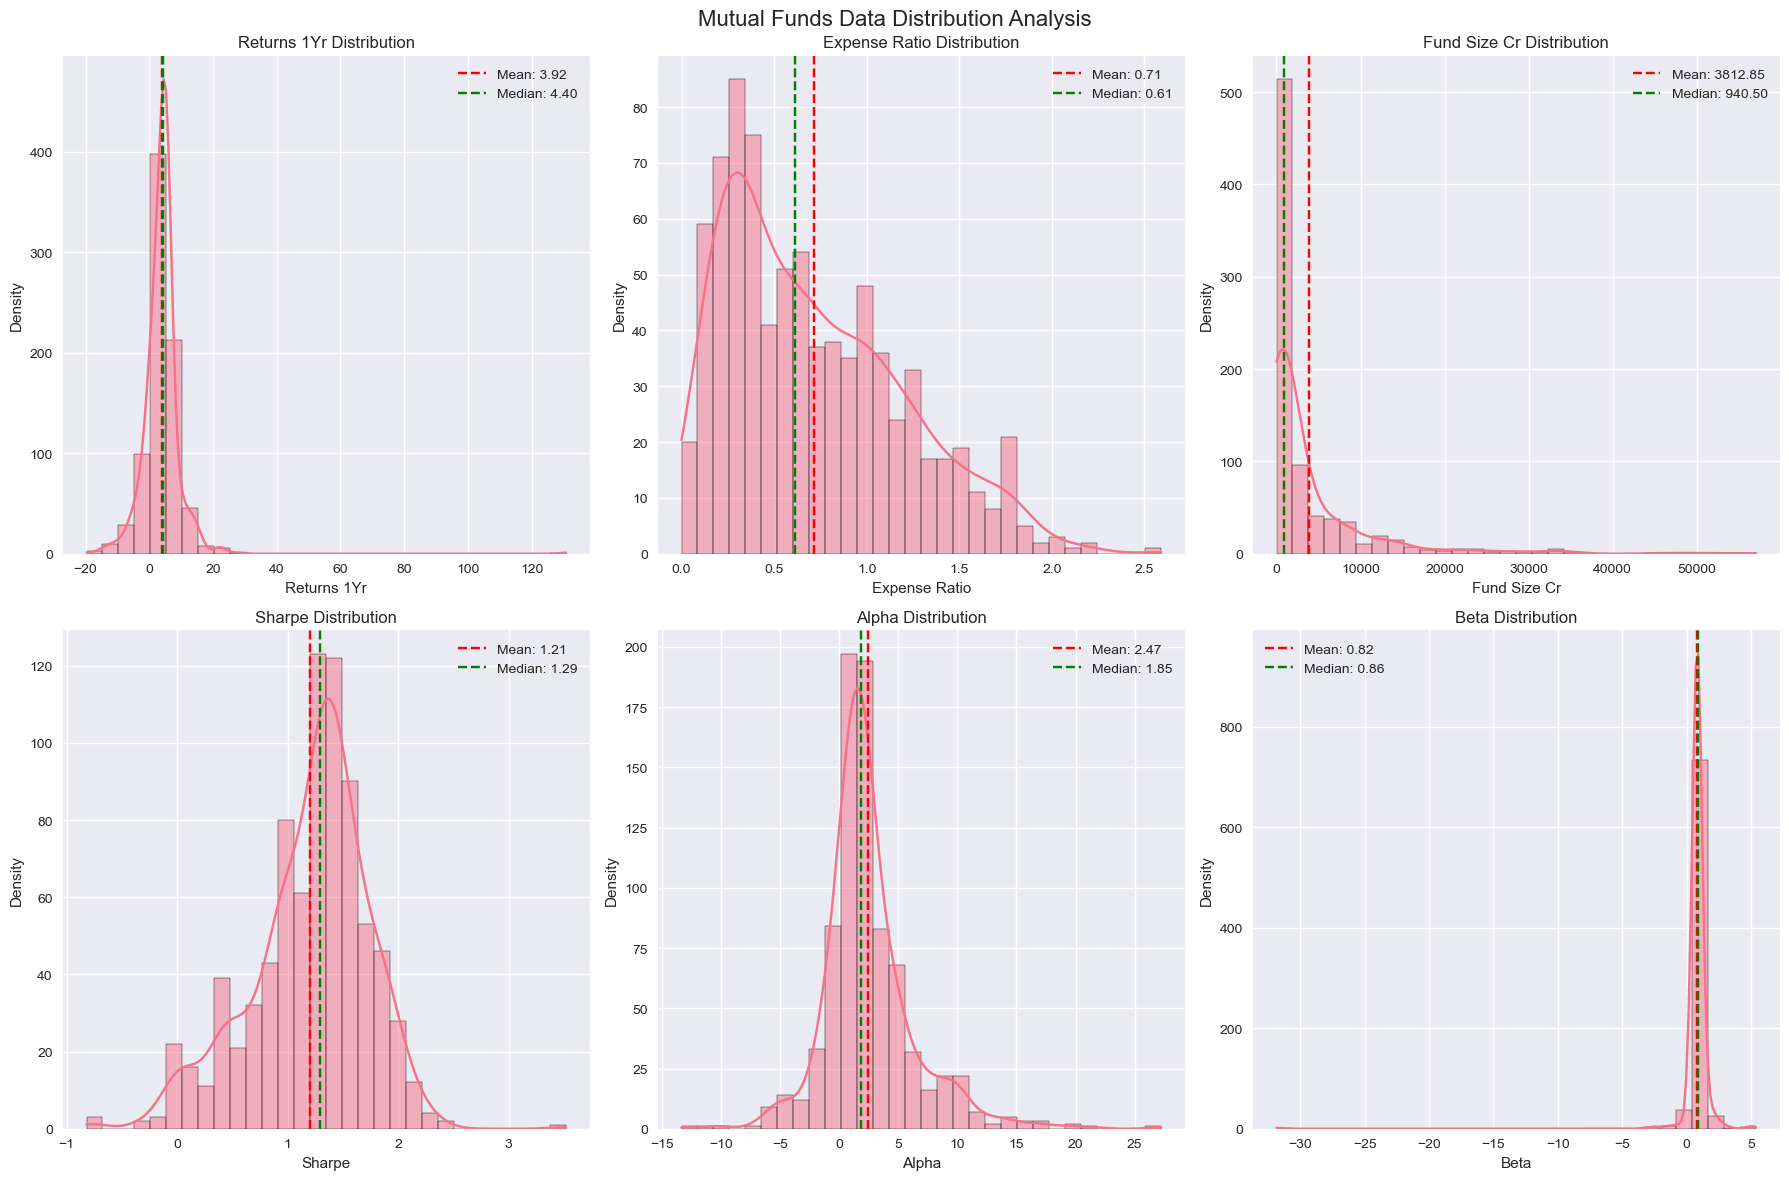

Saved 'enhanced_data_distributions.png'


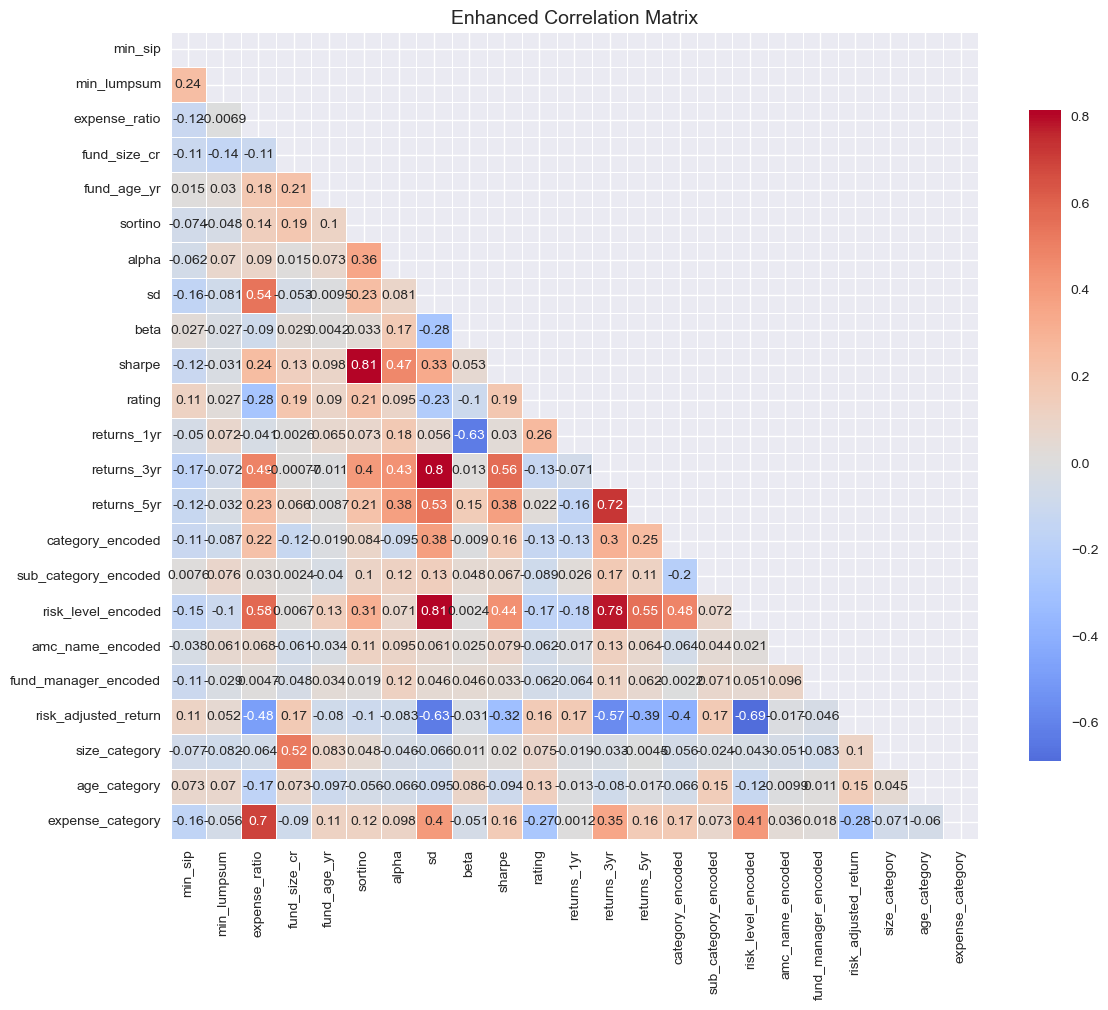

Saved 'enhanced_correlation_matrix.png'


In [32]:
# Cell 6: Visualize Distributions
# Create distribution plots and correlation heatmap.

def visualize_distributions(df):
    print("\n📈 CREATING VISUALIZATIONS")
    print("="*35)

    # Distribution plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Mutual Funds Data Distribution Analysis', fontsize=16)
    axes = axes.flatten()

    metrics = ['returns_1yr', 'expense_ratio', 'fund_size_cr', 'sharpe', 'alpha', 'beta']
    plot_index = 0
    for metric in metrics:
        if metric in df.columns and not df[metric].dropna().empty:
            sns.histplot(df[metric].dropna(), bins=30, kde=True, ax=axes[plot_index])
            axes[plot_index].set_title(f'{metric.replace("_", " ").title()} Distribution')
            axes[plot_index].set_xlabel(metric.replace("_", " ").title())
            axes[plot_index].set_ylabel('Density')
            mean_val = df[metric].mean()
            median_val = df[metric].median()
            axes[plot_index].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
            axes[plot_index].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
            axes[plot_index].legend()
            plot_index += 1
        else:
            print(f"Skipping distribution plot for '{metric}' as it's not available or empty.")

    for i in range(plot_index, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig('enhanced_data_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved 'enhanced_data_distributions.png'")

    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if not numeric_cols.empty:
        corr_matrix = df[numeric_cols].corr()
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                    square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Enhanced Correlation Matrix', fontsize=14)
        plt.tight_layout()
        plt.savefig('enhanced_correlation_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved 'enhanced_correlation_matrix.png'")
    else:
        print("No numerical columns available for correlation heatmap.")

# Call the function
visualize_distributions(df)


🎯 RQ1 – ENHANCED HIGH-RATED FUNDS CLASSIFICATION
Target 'is_high_rated' created.
Class Distribution:
is_high_rated
0    577
1    237
Name: count, dtype: int64

📊 Model Comparison:
--------------------------------------------------
Random Forest        | CV F1: 0.531±0.045 | Test F1: 0.532 | Test Acc: 0.773 | AUC: 0.793
Gradient Boosting    | CV F1: 0.589±0.035 | Test F1: 0.584 | Test Acc: 0.773 | AUC: 0.780
Logistic Regression  | CV F1: 0.602±0.054 | Test F1: 0.528 | Test Acc: 0.638 | AUC: 0.744
SVM                  | CV F1: 0.590±0.053 | Test F1: 0.569 | Test Acc: 0.675 | AUC: 0.770

🏆 Best Model: Logistic Regression

📋 Detailed Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.84      0.61      0.71       116
           1       0.42      0.70      0.53        47

    accuracy                           0.64       163
   macro avg       0.63      0.66      0.62       163
weighted avg       0.72      0.64      0.66 

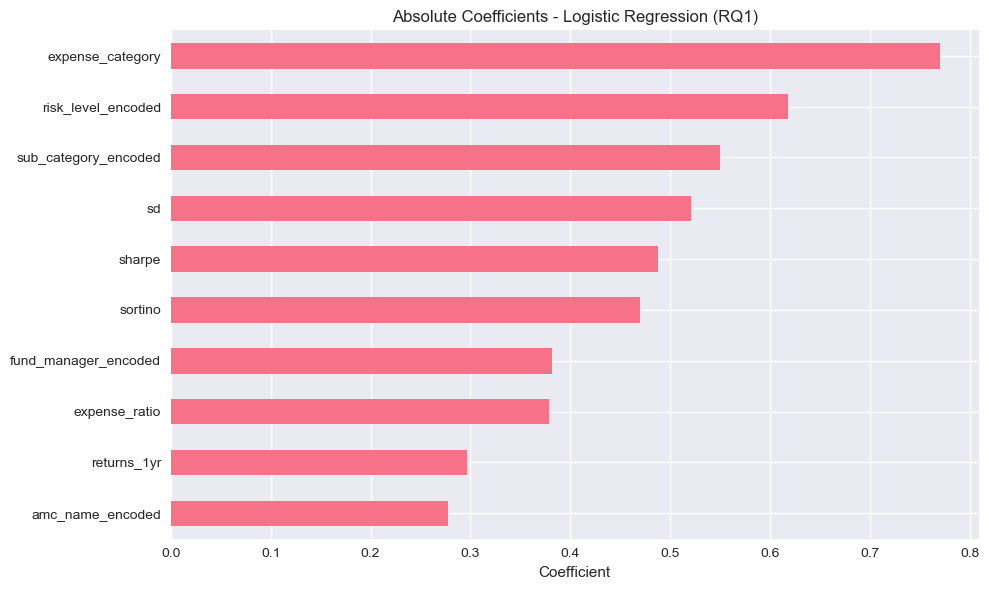

Saved 'enhanced_rq1_feature_importance_coef.png'


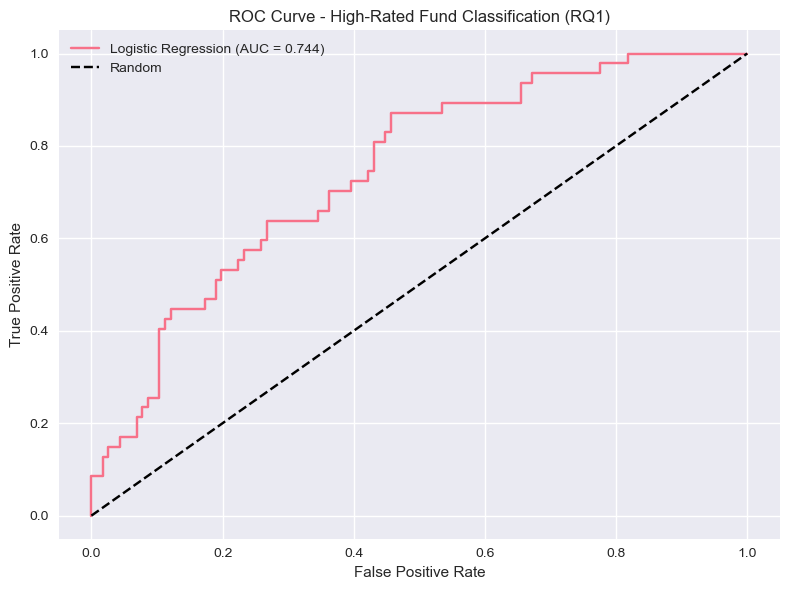

Saved 'enhanced_rq1_roc_curve.png'

Classification Results Summary: {'Random Forest': 0.5316455696202531, 'Gradient Boosting': 0.5842696629213483, 'Logistic Regression': 0.528, 'SVM': 0.5691056910569106}


In [33]:
# Cell 7: RQ1 - Classification of High-Rated Funds
# Identify features of highly-rated funds (rating >= 4) for RQ1.

def enhanced_rq1_classification(df, encoders):
    print("\n🎯 RQ1 – ENHANCED HIGH-RATED FUNDS CLASSIFICATION")
    print("="*55)

    if 'rating' not in df.columns:
        print("❌ 'rating' column not found.")
        return {}

    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df_cleaned_rq1 = df.dropna(subset=['rating']).copy()
    df_cleaned_rq1['is_high_rated'] = (df_cleaned_rq1['rating'] >= 4).astype(int)
    print("Target 'is_high_rated' created.")

    feature_candidates = ['expense_ratio', 'fund_size_cr', 'fund_age_yr', 'alpha',
                         'beta', 'sd', 'sharpe', 'sortino', 'risk_level_encoded',
                         'returns_1yr', 'risk_adjusted_return', 'size_category',
                         'age_category', 'expense_category', 'amc_name_encoded',
                         'category_encoded', 'sub_category_encoded', 'fund_manager_encoded']
    features_rq1 = [col for col in feature_candidates if col in df_cleaned_rq1.columns]
    if len(features_rq1) < 3:
        print("❌ Insufficient features for classification.")
        return {}

    X1 = df_cleaned_rq1[features_rq1].copy()
    y1 = df_cleaned_rq1['is_high_rated']

    imputer = SimpleImputer(strategy='median')
    X1_imputed = pd.DataFrame(imputer.fit_transform(X1), columns=X1.columns, index=X1.index)

    class_distribution = y1.value_counts()
    print(f"Class Distribution:\n{class_distribution}")
    if class_distribution.min() == 0:
        print("Warning: One class has zero samples.")
        return {}

    X1_train, X1_test, y1_train, y1_test = train_test_split(
        X1_imputed, y1, test_size=0.2, random_state=42, stratify=y1
    )

    numerical_cols_to_scale = X1_train.select_dtypes(include=[np.number]).columns
    scaler = RobustScaler()
    X1_train_scaled = X1_train.copy()
    X1_test_scaled = X1_test.copy()
    if not numerical_cols_to_scale.empty:
        X1_train_scaled[numerical_cols_to_scale] = scaler.fit_transform(X1_train[numerical_cols_to_scale])
        X1_test_scaled[numerical_cols_to_scale] = scaler.transform(X1_test[numerical_cols_to_scale])
        encoders['rq1_scaler'] = scaler

    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'SVM': SVC(random_state=42, class_weight='balanced', probability=True)
    }

    results = {}
    print("\n📊 Model Comparison:")
    print("-" * 50)
    for name, model in models.items():
        try:
            use_scaled = name in ['SVM', 'Logistic Regression']
            X_tr = X1_train_scaled if use_scaled else X1_train
            X_te = X1_test_scaled if use_scaled else X1_test
            cv_scores = cross_val_score(model, X_tr, y1_train,
                                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                       scoring='f1')
            model.fit(X_tr, y1_train)
            y_pred = model.predict(X_te)
            y_pred_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None
            accuracy = accuracy_score(y1_test, y_pred)
            f1 = f1_score(y1_test, y_pred)
            auc = roc_auc_score(y1_test, y_pred_proba) if y_pred_proba is not None else None
            results[name] = {
                'model': model,
                'cv_f1_mean': cv_scores.mean(),
                'cv_f1_std': cv_scores.std(),
                'test_accuracy': accuracy,
                'test_f1': f1,
                'test_auc': auc,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            print(f"{name:20} | CV F1: {cv_scores.mean():.3f}±{cv_scores.std():.3f} | "
                  f"Test F1: {f1:.3f} | Test Acc: {accuracy:.3f}" +
                  (f" | AUC: {auc:.3f}" if auc else ""))
        except Exception as e:
            print(f"Error training {name}: {e}")

    if not results:
        print("No models trained successfully.")
        return {}

    best_model_name = max(results, key=lambda x: results[x]['cv_f1_mean'])
    best_result = results[best_model_name]
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"\n📋 Detailed Classification Report ({best_model_name}):")
    print(classification_report(y1_test, best_result['predictions']))

    if hasattr(best_result['model'], 'feature_importances_'):
        feature_importance = pd.Series(best_result['model'].feature_importances_,
                                      index=features_rq1).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        feature_importance.head(10).plot(kind='barh')
        plt.gca().invert_yaxis()
        plt.title(f'Feature Importance - {best_model_name} (RQ1)')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.savefig('enhanced_rq1_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved 'enhanced_rq1_feature_importance.png'")
    elif hasattr(best_result['model'], 'coef_'):
        feature_importance = pd.Series(np.abs(best_result['model'].coef_[0]),
                                      index=features_rq1).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        feature_importance.head(10).plot(kind='barh')
        plt.gca().invert_yaxis()
        plt.title(f'Absolute Coefficients - {best_model_name} (RQ1)')
        plt.xlabel('Coefficient')
        plt.tight_layout()
        plt.savefig('enhanced_rq1_feature_importance_coef.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved 'enhanced_rq1_feature_importance_coef.png'")

    if best_result['probabilities'] is not None:
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y1_test, best_result['probabilities'])
        plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {best_result["test_auc"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - High-Rated Fund Classification (RQ1)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('enhanced_rq1_roc_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved 'enhanced_rq1_roc_curve.png'")

    return results

# Call the function
classification_results = enhanced_rq1_classification(df, encoders)
print("\nClassification Results Summary:", {k: v['test_f1'] for k, v in classification_results.items() if 'test_f1' in v})


🎯 RQ2 – ENHANCED CLUSTERING ANALYSIS
Using features for clustering: ['sharpe', 'sortino', 'alpha', 'beta', 'sd', 'returns_1yr', 'expense_ratio', 'fund_size_cr', 'fund_age_yr']

🔍 Finding optimal number of clusters for K-Means...
k=2: SSE=6055.89, Silhouette=0.210
k=3: SSE=4937.57, Silhouette=0.217
k=4: SSE=4191.05, Silhouette=0.203
k=5: SSE=3659.05, Silhouette=0.223
k=6: SSE=3224.56, Silhouette=0.238
k=7: SSE=2832.23, Silhouette=0.247
k=8: SSE=2626.28, Silhouette=0.252
k=9: SSE=2469.09, Silhouette=0.224
k=10: SSE=2365.65, Silhouette=0.217

🎯 Optimal k selected for K-Means: 8

🔍 Trying DBSCAN clustering...
DBSCAN clustering with eps=1.20, min_samples=15, silhouette=0.104

📊 Cluster Analysis (K-Means, k=8):

Cluster 0 (n=217):
        sharpe  sortino    alpha  ...  expense_ratio  fund_size_cr  fund_age_yr
count  217.000  217.000  217.000  ...        217.000       217.000      217.000
mean     1.248    2.717    0.482  ...          1.072      2621.854        9.650
std      0.254    0.660 

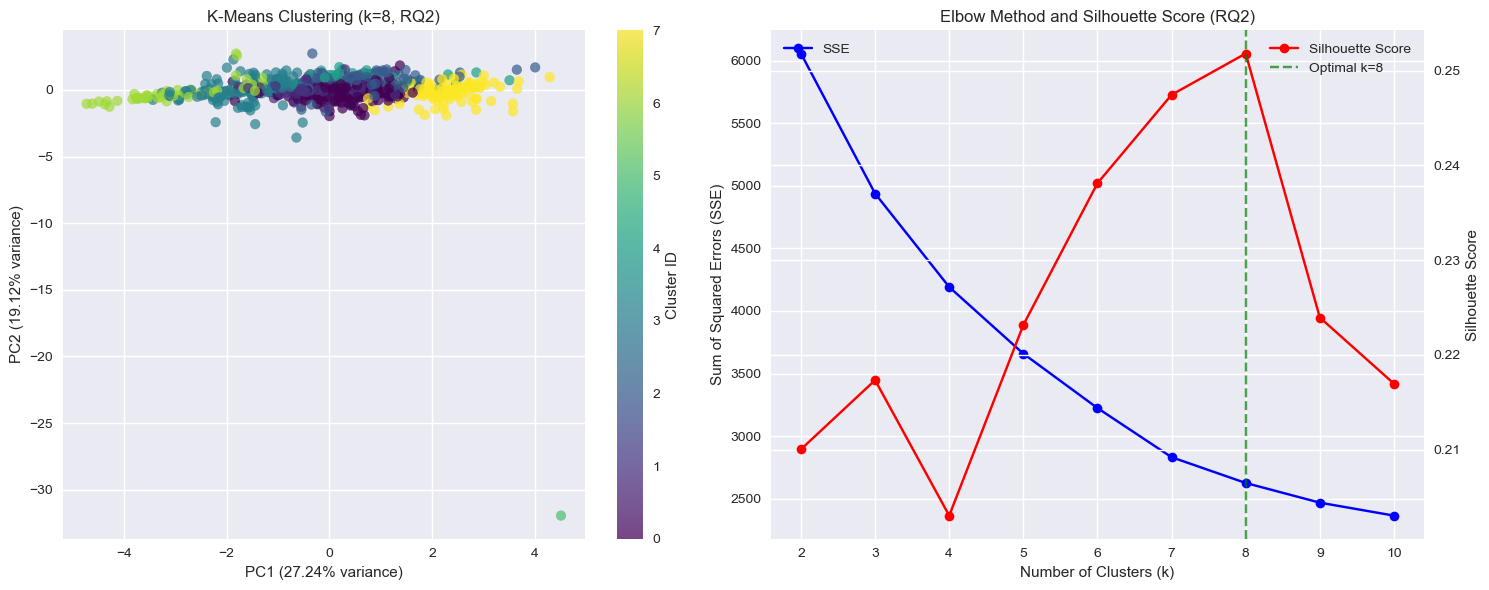

Saved 'enhanced_rq2_clustering_analysis.png'
Saved interactive clustering plot to 'enhanced_rq2_clustering_interactive.html'

Clustering Results: {'optimal_k': 8, 'dbscan_score': 0.10359197201894157}


In [37]:
# Cell 8: RQ2 - Clustering Analysis
# Group funds by risk and return characteristics for RQ2.

def enhanced_rq2_clustering(df, encoders):
    print("\n🎯 RQ2 – ENHANCED CLUSTERING ANALYSIS")
    print("="*40)

    cluster_features = ['sharpe', 'sortino', 'alpha', 'beta', 'sd', 'returns_1yr', 'expense_ratio',
                       'fund_size_cr', 'fund_age_yr']
    available_features = [col for col in cluster_features if col in df.columns]
    if len(available_features) < 2:
        print("❌ Insufficient features for clustering.")
        return {}

    print(f"Using features for clustering: {available_features}")
    X2 = df[available_features].copy()
    imputer = SimpleImputer(strategy='median')
    X2_imputed = pd.DataFrame(imputer.fit_transform(X2), columns=X2.columns, index=X2.index)
    scaler = StandardScaler()
    X2_scaled = scaler.fit_transform(X2_imputed)
    encoders['rq2_scaler'] = scaler

    k_range = range(2, min(11, len(X2_scaled) // 10))
    if len(k_range) < 2:
        print("Insufficient data points for clustering.")
        return {}

    sse = []
    silhouette_scores = []
    print("\n🔍 Finding optimal number of clusters for K-Means...")
    for k in k_range:
        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X2_scaled)
            sse.append(kmeans.inertia_)
            if len(set(cluster_labels)) > 1:
                sil_score = silhouette_score(X2_scaled, cluster_labels)
                silhouette_scores.append(sil_score)
            else:
                silhouette_scores.append(-1)
            print(f"k={k}: SSE={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")
        except Exception as e:
            print(f"Error calculating KMeans for k={k}: {e}")
            sse.append(np.nan)
            silhouette_scores.append(np.nan)

    valid_silhouette_scores = [s for s in silhouette_scores if not np.isnan(s) and s != -1]
    valid_k_range = [k_range[i] for i, s in enumerate(silhouette_scores) if not np.isnan(s) and s != -1]
    optimal_k = valid_k_range[np.argmax(valid_silhouette_scores)] if valid_k_range else 3
    print(f"\n🎯 Optimal k selected for K-Means: {optimal_k}")

    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['cluster_kmeans'] = kmeans_final.fit_predict(X2_scaled)

    print("\n🔍 Trying DBSCAN clustering...")
    eps_values = np.linspace(0.1, 2.0, 20)
    min_samples_values = [5, 10, 15]
    best_dbscan_score = -1
    best_eps = None
    best_min_samples = None
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(X2_scaled)
            n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            if n_clusters >= 2:
                try:
                    score = silhouette_score(X2_scaled, cluster_labels)
                    if score > best_dbscan_score:
                        best_dbscan_score = score
                        best_eps = eps
                        best_min_samples = min_samples
                except ValueError:
                    pass
    if best_eps is not None:
        dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
        df['cluster_dbscan'] = dbscan_final.fit_predict(X2_scaled)
        print(f"DBSCAN clustering with eps={best_eps:.2f}, min_samples={best_min_samples}, silhouette={best_dbscan_score:.3f}")
    else:
        print("Could not find a suitable DBSCAN configuration.")
        df['cluster_dbscan'] = -1

    print(f"\n📊 Cluster Analysis (K-Means, k={optimal_k}):")
    for i in range(optimal_k):
        cluster_data = df[df['cluster_kmeans'] == i]
        if not cluster_data.empty:
            print(f"\nCluster {i} (n={len(cluster_data)}):")
            print(cluster_data[available_features].describe().round(3))
        else:
            print(f"\nCluster {i} is empty.")

    # PCA and Visualization
    pca = PCA(n_components=2)
    X2_pca = pca.fit_transform(X2_scaled)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    pca_df = pd.DataFrame(X2_pca, columns=['PC1', 'PC2'], index=df.index)
    pca_df['cluster'] = df['cluster_kmeans']
    pca_df['scheme_name'] = df['scheme_name']  # Add scheme_name for identification

    # Identify the mutual fund at the bottom-right (high PC1, low PC2)
    target_dot = pca_df.loc[(pca_df['PC1'] == pca_df['PC1'].max()) & (pca_df['PC2'] == pca_df['PC2'].min())]
    if not target_dot.empty:
        print(f"\nMutual Fund at right-hand bottom (high PC1, low PC2):")
        print(target_dot[['scheme_name', 'PC1', 'PC2', 'cluster']])
    else:
        # If no exact match, take the fund with highest PC1 and closest to min PC2
        closest_bottom = pca_df.iloc[(pca_df['PC1'] - pca_df['PC1'].max()).abs().argsort()[:1] & 
                                    (pca_df['PC2'] - pca_df['PC2'].min()).abs().argsort()[:1]]
        print(f"\nClosest Mutual Fund to right-hand bottom (high PC1, low PC2):")
        print(closest_bottom[['scheme_name', 'PC1', 'PC2', 'cluster']])

    scatter = axes[0].scatter(pca_df['PC1'], pca_df['PC2'],
                             c=pca_df['cluster'], cmap='viridis', alpha=0.7)
    axes[0].set_title(f'K-Means Clustering (k={optimal_k}, RQ2)')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter, ax=axes[0], label='Cluster ID')

    if valid_k_range:
        axes[1].plot(k_range, sse, 'bo-', label='SSE')
        axes[1].set_xlabel('Number of Clusters (k)')
        axes[1].set_ylabel('Sum of Squared Errors (SSE)')
        axes[1].set_title('Elbow Method and Silhouette Score (RQ2)')
        axes[1].grid(True)
        ax2 = axes[1].twinx()
        ax2.plot(valid_k_range, valid_silhouette_scores, 'ro-', label='Silhouette Score')
        ax2.set_ylabel('Silhouette Score')
        ax2.axvline(x=optimal_k, color='green', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
        axes[1].legend(loc='upper left')
        ax2.legend(loc='upper right')
    else:
        axes[1].text(0.5, 0.5, "Not enough data points for elbow/silhouette plot.",
                    horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
        axes[1].set_title("Elbow Method and Silhouette Score (RQ2)")
        axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('enhanced_rq2_clustering_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved 'enhanced_rq2_clustering_analysis.png'")

    try:
        df_for_plotly = df.copy()
        df_for_plotly['PC1'] = X2_pca[:, 0]
        df_for_plotly['PC2'] = X2_pca[:, 1]
        if 'cluster_kmeans' in df_for_plotly.columns:
            fig_plotly = px.scatter(df_for_plotly, x='PC1', y='PC2', color='cluster_kmeans',
                                   title=f'Interactive K-Means Clustering (k={optimal_k}, RQ2) with PCA',
                                   hover_data=available_features + ['cluster_kmeans', 'scheme_name'])
            fig_plotly.write_html('enhanced_rq2_clustering_interactive.html')
            print("Saved interactive clustering plot to 'enhanced_rq2_clustering_interactive.html'")
    except Exception as e:
        print(f"Could not generate interactive Plotly graph: {e}")

    return {'optimal_k': optimal_k, 'dbscan_score': best_dbscan_score if best_eps is not None else None}

# Call the function
clustering_results = enhanced_rq2_clustering(df, encoders)
print("\nClustering Results:", clustering_results) 



🎯 RQ3 – ENHANCED RETURNS PREDICTION

📊 Regression Model Comparison:
------------------------------------------------------------
Random Forest        | CV R²: 0.960±0.016 | Test R²: 0.983 | RMSE: 0.521 | MAE: 0.291
Ridge Regression     | CV R²: 0.252±0.087 | Test R²: 0.321 | RMSE: 3.328 | MAE: 2.248
Gradient Boosting    | CV R²: 0.970±0.003 | Test R²: 0.987 | RMSE: 0.459 | MAE: 0.304

🏆 Best Model: Gradient Boosting
Test R²: 0.987 | RMSE: 0.459 | MAE: 0.304


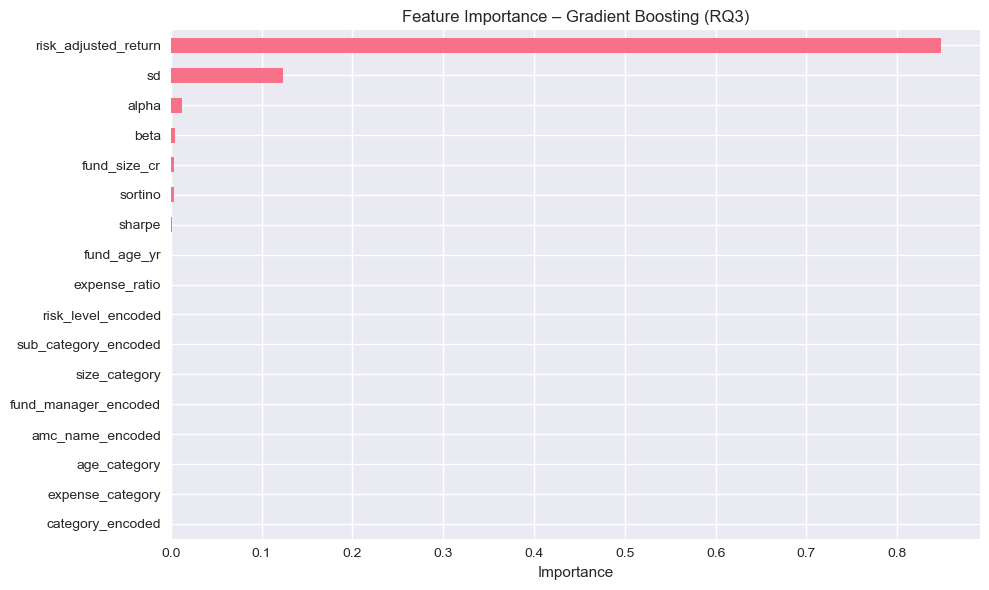

Saved 'enhanced_rq3_feature_importance.png'


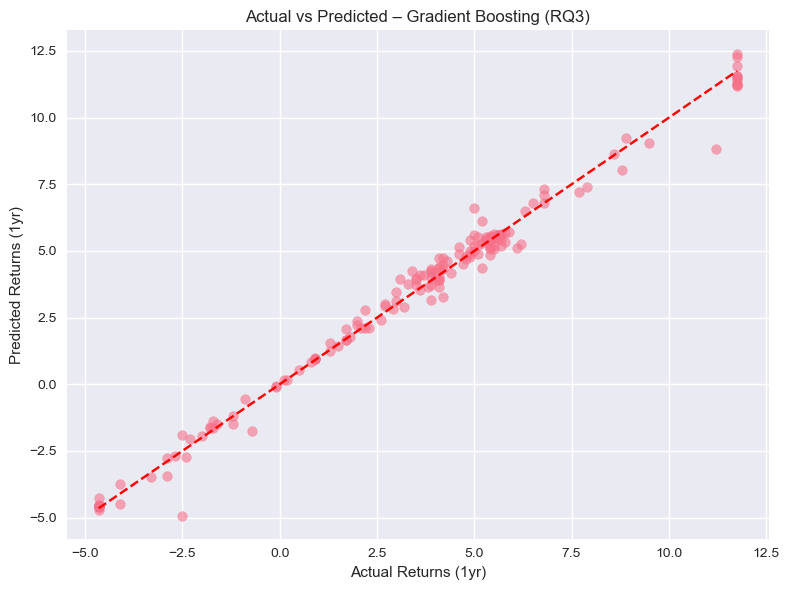

Saved 'enhanced_rq3_actual_vs_predicted.png'

Regression Results Summary: {'Random Forest': 0.9833740475673428, 'Ridge Regression': 0.32106055801440847, 'Gradient Boosting': 0.9870607053574239}


In [38]:
# Cell 9: RQ3 - Regression for Returns Prediction
# Predict 1-year returns for RQ3.

def enhanced_rq3_regression(df, encoders):
    print("\n🎯 RQ3 – ENHANCED RETURNS PREDICTION")
    print("=" * 40)

    if 'returns_1yr' not in df.columns:
        print("❌ 'returns_1yr' column not found.")
        return {}

    df['returns_1yr'] = pd.to_numeric(df['returns_1yr'], errors='coerce')
    if df['returns_1yr'].dropna().shape[0] < 30:
        print("❌ Not enough valid 'returns_1yr' data.")
        return {}

    feature_candidates = [
        'expense_ratio', 'fund_size_cr', 'fund_age_yr', 'alpha', 'beta', 'sd',
        'sharpe', 'sortino', 'risk_level_encoded', 'risk_adjusted_return',
        'size_category', 'age_category', 'expense_category', 'amc_name_encoded',
        'category_encoded', 'sub_category_encoded', 'fund_manager_encoded'
    ]
    features_rq3 = [col for col in feature_candidates if col in df.columns]
    if len(features_rq3) < 2:
        print("❌ Not enough valid features.")
        return {}

    X = df[features_rq3].copy()
    y = df['returns_1yr'].copy()
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    y = y.fillna(y.median())
    q1, q3 = y.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    y = y.clip(lower, upper)

    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    encoders['rq3_scaler'] = scaler

    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Ridge Regression': Ridge(alpha=1.0),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    results = {}
    print("\n📊 Regression Model Comparison:")
    print("-" * 60)
    for name, model in models.items():
        try:
            X_train_use = X_train_scaled if name == 'Ridge Regression' else X_train
            X_test_use = X_test_scaled if name == 'Ridge Regression' else X_test
            cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='r2')
            model.fit(X_train_use, y_train)
            y_pred = model.predict(X_test_use)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            results[name] = {
                'model': model,
                'cv_r2_mean': cv_scores.mean(),
                'cv_r2_std': cv_scores.std(),
                'test_rmse': rmse,
                'test_mae': mae,
                'test_r2': r2,
                'predictions': y_pred
            }
            print(f"{name:20} | CV R²: {cv_scores.mean():.3f}±{cv_scores.std():.3f} | "
                  f"Test R²: {r2:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}")
        except Exception as e:
            print(f"❌ Error in {name}: {e}")

    if not results:
        print("❌ All models failed.")
        return {}

    best_model_name = max(results, key=lambda x: results[x]['cv_r2_mean'])
    best_result = results[best_model_name]
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"Test R²: {best_result['test_r2']:.3f} | RMSE: {best_result['test_rmse']:.3f} | MAE: {best_result['test_mae']:.3f}")

    # Feature Importance Plot
    if hasattr(best_result['model'], 'feature_importances_'):
        importances = pd.Series(best_result['model'].feature_importances_, index=features_rq3)
        plt.figure(figsize=(10, 6))
        importances.sort_values(ascending=True).plot(kind='barh')
        plt.title(f'Feature Importance – {best_model_name} (RQ3)')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.savefig('enhanced_rq3_feature_importance.png', dpi=300)
        plt.show()
        print("Saved 'enhanced_rq3_feature_importance.png'")
    elif hasattr(best_result['model'], 'coef_'):
        coef = pd.Series(np.abs(best_result['model'].coef_), index=features_rq3)
        plt.figure(figsize=(10, 6))
        coef.sort_values(ascending=True).plot(kind='barh')
        plt.title(f'Absolute Coefficients – {best_model_name} (RQ3)')
        plt.xlabel('Coefficient')
        plt.tight_layout()
        plt.savefig('enhanced_rq3_feature_coefficients.png', dpi=300)
        plt.show()
        print("Saved 'enhanced_rq3_feature_coefficients.png'")

    # Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, best_result['predictions'], alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Returns (1yr)')
    plt.ylabel('Predicted Returns (1yr)')
    plt.title(f'Actual vs Predicted – {best_model_name} (RQ3)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('enhanced_rq3_actual_vs_predicted.png', dpi=300)
    plt.show()
    print("Saved 'enhanced_rq3_actual_vs_predicted.png'")

    return results

# Call the function
regression_results = enhanced_rq3_regression(df, encoders)
print("\nRegression Results Summary:", {k: v['test_r2'] for k, v in regression_results.items() if 'test_r2' in v})